# Lending Club Loan Data: Exploratory Data Analysis

## Description: Analyze Lending Club's issued loans

These files contain ***complete*** **loan data** for all loans issued through the **2007-2015**, including the **current loan status (`'Current'`, `'Late'`, `'Fully Paid'`, etc.)** and **latest payment information**. Additional features include **credit scores**, **number of finance inquiries**, **address** including **zip codes**, and **state**, and **collections** among others. The file is a matrix of about 890 thousand observations and 75 variables. Here, we use a previously transformed data set, which is however a full copy of the original one. For more information, or if you want to download these data, consult:

## Source

* [Lending Club - About](https://www.lendingclub.com/public/about-us.action)
* [Lending Club Statistics - Download Data](https://www.lendingclub.com/info/download-data.action)
* [kaggle Datasets](https://www.kaggle.com/wendykan/lending-club-loan-data)

## 1. Loading Libraries and User-defined Functions

In [1]:
# Required Libraries
import os
import pandas as pd
import numpy as np
import folium

from pprint import pprint
#from time import time
from __future__ import print_function
np.set_printoptions(precision=4, suppress=True)

from matplotlib import pyplot as plt
import matplotlib as mlb
import seaborn as sns

In [2]:
# Matplotlib/Seaborn Parameters
mlb.style.use('seaborn-whitegrid')
sns.set_context('talk')
%matplotlib inline

mlb.rcParams['figure.titleweight'] = 'bold'
mlb.rcParams['axes.labelweight'] = 'bold'
mlb.rcParams['axes.titleweight'] = 'bold'
mlb.rcParams['figure.figsize'] = [10,6]

In [3]:
# User-defined Functions [Loaded from: /media/ML_HOME/ML-Code_Base (through a .pth file)]
from visualization_helper_functions import freq_tables
from ML_helper_functions import cv_estimate

In [4]:
# Path Definitions of Required Data Sets
loan_df_path = os.path.join('/media/ML_HOME/ML-Data_Repository/', 'loan_df')
us_states_TopoJSON = os.path.join('/media/ML_HOME/ML-Data_Repository/', 'us_states-topo.json')

## 2. Loading Loan Data / Validity Checks

The **`loan.csv`** has been loaded and transformed using the **`lending_club_loan_data-eda.py`** script. The data types of the all the attributes have been appropriately defined, as well as the categories of all the nominal and ordinal categorical variables. The transformed data set has ~890 observations, 75 attributes, and it is 502MB in size. Note, that some **`'NA'`** values exist in specific **`float`** and **`str`** variables, but this is expected.

In [5]:
loan_df = pd.read_pickle(loan_df_path)

In [6]:
loan_df.shape

(887379, 74)

In [7]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null category
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null category
sub_grade                      887379 non-null category
emp_title                      835922 non-null object
emp_length                     887379 non-null category
home_ownership                 887379 non-null category
annual_inc                     887375 non-null float64
verification_status            887379 non-null category
issue_d                        887379 non-null datetime64[ns]
l

In [8]:
loan_df.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599     5000.0       5000.0           4975.0   36 months   
1  1077430    1314167     2500.0       2500.0           2500.0   60 months   
2  1077175    1313524     2400.0       2400.0           2400.0   36 months   
3  1076863    1277178    10000.0      10000.0          10000.0   36 months   
4  1075358    1311748     3000.0       3000.0           3000.0   60 months   

   int_rate  installment grade sub_grade     ...      total_bal_il il_util  \
0     10.65       162.87     B        B2     ...               NaN     NaN   
1     15.27        59.83     C        C4     ...               NaN     NaN   
2     15.96        84.33     C        C5     ...               NaN     NaN   
3     13.49       339.31     C        C1     ...               NaN     NaN   
4     12.69        67.79     B        B5     ...               NaN     NaN   

  open_rv_12m  open_rv_24m max_bal_bc all_util total_rev_hi_lim inq_fi  \
0       -9999        -9999        NaN      NaN              NaN  -9999   
1       -9999        -9999        NaN      NaN              NaN  -9999   
2       -9999        -9999        NaN      NaN              NaN  -9999   
3       -9999        -9999        NaN      NaN              NaN  -9999   
4       -9999        -9999        NaN      NaN              NaN  -9999   

  total_cu_tl inq_last_12m  
0       -9999        -9999  
1       -9999        -9999  
2       -9999        -9999  
3       -9999        -9999  
4       -9999        -9999  

[5 rows x 74 columns]

### A. Uniqueness of `'id'` and `'member_id'` as a surrogate table key [no duplicated records]

* **`'id'`:** A unique LC assigned ID for the loan listing.
* **`'member_id'`:** A unique LC assigned Id for the borrower member.

In [9]:
num_unique_values = len(pd.unique(loan_df['id']))
num_records = len(loan_df['id'])
is_key = (num_unique_values == num_records)
print('Checks the uniqueness of \'id\' [key]: %s' % is_key)

Checks the uniqueness of 'id' [key]: True


In [10]:
num_unique_values = len(pd.unique(loan_df['member_id']))
num_records = len(loan_df['member_id'])
is_key = (num_unique_values == num_records)
print('Checks the uniqueness of \'member_id\' [key]: %s' % is_key)

Checks the uniqueness of 'member_id' [key]: True


### B. Validity of date fields

All **date fields** are valid:

* **`'issue_d'`:** The month which the loan was funded (`'Jun-2007'`-`'Dec-2015'`).
* **`'earliest_cr_line'`:** The month the borrower's earliest reported credit line was opened (`'Jan-1944'`-`'Nov-2012'`).
* **`'last_pymnt_d'`:** Last month payment was received (`'Dec-2007'`-`'Jan-2016'`).
* **`'next_pymnt_d'`:** Next scheduled payment date (`'Dec-2007'`-`'Mar-2016'`).
* **`'last_credit_pull_d'`:** The most recent month LC pulled credit for this loan (`'May-2007'`-`'Jan-2016'`).

In [11]:
loan_df.select_dtypes(include=['datetime64']).describe()

issue_d     earliest_cr_line         last_pymnt_d  \
count                887379               887350               869720   
unique                  103                  697                   98   
top     2015-10-01 00:00:00  2001-08-01 00:00:00  2016-01-01 00:00:00   
freq                  48631                 6659               470150   
first   2007-06-01 00:00:00  1944-01-01 00:00:00  2007-12-01 00:00:00   
last    2015-12-01 00:00:00  2012-11-01 00:00:00  2016-01-01 00:00:00   

               next_pymnt_d   last_credit_pull_d  
count                634408               887326  
unique                  100                  103  
top     2016-02-01 00:00:00  2016-01-01 00:00:00  
freq                 553406               730574  
first   2007-12-01 00:00:00  2007-05-01 00:00:00  
last    2016-03-01 00:00:00  2016-01-01 00:00:00

In [12]:
dt_attribs = list(loan_df.select_dtypes(include=['datetime64']).columns)
dt_attribs

['issue_d',
 'earliest_cr_line',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d']

In [13]:
for attrib in dt_attribs:
    pprint(loan_df.loc[:3,attrib])
    print('\n')

0   2011-12-01
1   2011-12-01
2   2011-12-01
3   2011-12-01
Name: issue_d, dtype: datetime64[ns]


0   1985-01-01
1   1999-04-01
2   2001-11-01
3   1996-02-01
Name: earliest_cr_line, dtype: datetime64[ns]


0   2015-01-01
1   2013-04-01
2   2014-06-01
3   2015-01-01
Name: last_pymnt_d, dtype: datetime64[ns]


0   NaT
1   NaT
2   NaT
3   NaT
Name: next_pymnt_d, dtype: datetime64[ns]


0   2016-01-01
1   2013-09-01
2   2016-01-01
3   2015-01-01
Name: last_credit_pull_d, dtype: datetime64[ns]




### C. Text Attributes

Some **`'NA'`** values exist, but this is not a problem for text attributes. In particular, these **text attributes** are:

* **`'emp_title'`**: The job title supplied by the Borrower when applying for the loan (Employer Title replaces Employer Name for all loans listed after 9/23/2013).
* **`'url'`**: URL for the LC page with listing data.
* **`'desc'`**: Loan description provided by the borrower.
* **`'title'`**: The loan title provided by the borrower.

and we are not going to use them, in this first stage of predictive modelling.

In [14]:
loan_df.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 5 columns):
emp_title      835922 non-null object
loan_status    887379 non-null object
url            887379 non-null object
desc           126029 non-null object
title          887228 non-null object
dtypes: object(5)
memory usage: 33.9+ MB


In [15]:
str_attribs = list(loan_df.select_dtypes(include=['object']).columns)
str_attribs

['emp_title', 'loan_status', 'url', 'desc', 'title']

In [16]:
for attrib in str_attribs:
    pprint(loan_df.loc[:3, attrib])
    print('\n')

0                    NaN
1                  Ryder
2                    NaN
3    AIR RESOURCES BOARD
Name: emp_title, dtype: object


0     Fully Paid
1    Charged Off
2     Fully Paid
3     Fully Paid
Name: loan_status, dtype: object


0    https://www.lendingclub.com/browse/loanDetail....
1    https://www.lendingclub.com/browse/loanDetail....
2    https://www.lendingclub.com/browse/loanDetail....
3    https://www.lendingclub.com/browse/loanDetail....
Name: url, dtype: object


0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                  NaN
3      Borrower added on 12/21/11 > to pay for prop...
Name: desc, dtype: object


0                Computer
1                    bike
2    real estate business
3                personel
Name: title, dtype: object




### D. Float Attributes

All **float attributes** are important for the predictive model we want to build. Some specific attributes, such as the **`'dti_joint'`**  and the **`'annual_inc_joint`'**, have a plethora of **`'NA'`** values, but this is reasonable and expected.

* **`'loan_amnt'`:** The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* **`'funded_amnt'`:** The total amount committed to that loan at that point in time.
* **`'funded_amnt_inv'`:** The total amount committed by investors for that loan at that point in time.
* **`'int_rate'`:** Interest Rate on the loan.
* **`'installment'`:** The monthly payment owed by the borrower if the loan originates.
* **`'annual_inc'`:** The self-reported annual income provided by the borrower during registration.
* **`'dti'`:** A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* **`'revol_bal'`:** Total credit revolving balance.
* **`'revol_util'`:** Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* **`'out_prncp'`:** Remaining outstanding principal for total amount funded.
* **`'out_prncp_inv'`:** Remaining outstanding principal for portion of total amount funded by investors.
* **`'total_pymnt'`:** Payments received to date for total amount funded.
* **`'total_pymnt_inv'`:** Payments received to date for portion of total amount funded by investors.
* **`'total_rec_prncp'`:** Principal received to date.
* **`'total_rec_int'`:** Interest received to date.
* **`'total_rec_late_fee'`:** Late fees received to date.
* **`'recoveries'`:** Post charge off gross recovery.
* **`'collection_recovery_fee'`:** Post charge off collection fee.
* **`'last_pymnt_amnt'`:** Last total payment amount received.
* **`'annual_inc_joint'`:** The combined self-reported annual income provided by the co-borrowers during registration
* **`'dti_joint'`:** A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income.
* **`'tot_cur_bal'`:** Total current balance of all accounts.
* **`'total_bal_il'`:** Total current balance of all installment accounts.
* **`'il_util'`:** Ratio of total current balance to high credit/credit limit on all install acct.
* **`'max_bal_bc'`:** Maximum current balance owed on all revolving accounts.
* **`'all_util'`:** Balance to credit limit on all trades.
* **`'total_rev_hi_lim '`:** Total revolving high credit/credit limit.

In [17]:
loan_df.select_dtypes(include=['float']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 27 columns):
loan_amnt                  887379 non-null float64
funded_amnt                887379 non-null float64
funded_amnt_inv            887379 non-null float64
int_rate                   887379 non-null float64
installment                887379 non-null float64
annual_inc                 887375 non-null float64
dti                        887379 non-null float64
revol_bal                  887379 non-null float64
revol_util                 886877 non-null float64
out_prncp                  887379 non-null float64
out_prncp_inv              887379 non-null float64
total_pymnt                887379 non-null float64
total_pymnt_inv            887379 non-null float64
total_rec_prncp            887379 non-null float64
total_rec_int              887379 non-null float64
total_rec_late_fee         887379 non-null float64
recoveries                 887379 non-null float64
collection_recovery_fe

In [18]:
pprint(loan_df.select_dtypes(include=['float']).describe())

           loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
count  887379.000000  887379.000000    887379.000000  887379.000000   
mean    14755.264605   14741.877625     14702.464383      13.246740   
std      8435.455601    8429.897657      8442.106732       4.381867   
min       500.000000     500.000000         0.000000       5.320000   
25%      8000.000000    8000.000000      8000.000000       9.990000   
50%     13000.000000   13000.000000     13000.000000      12.990000   
75%     20000.000000   20000.000000     20000.000000      16.200000   
max     35000.000000   35000.000000     35000.000000      28.990000   

         installment    annual_inc            dti     revol_bal  \
count  887379.000000  8.873750e+05  887379.000000  8.873790e+05   
mean      436.717127  7.502759e+04      18.157039  1.692079e+04   
std       244.186593  6.469830e+04      17.190626  2.242679e+04   
min        15.670000  0.000000e+00       0.000000  0.000000e+00   
25%       260.705000  4.5

### E. Integer Attributes

All **integer attributes** are important for the predictive model we want to build. The **`'NA'`** values where exist have been set to `'-9999'`.

* **`'delinq_2yrs'`:** The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.
* **`'inq_last_6mths'`:** Number of credit inquiries in past 12 months.
* **`'mths_since_last_delinq'`:** The number of months since the borrower's last delinquency.
* **`'mths_since_last_record'`:** The number of months since the last public record.
* **`'open_acc'`:** The number of open credit lines in the borrower's credit file.
* **`'pub_rec'`:** Number of derogatory public records.
* **`'total_acc'`:** The total number of credit lines currently in the borrower's credit file.
* **`'collections_12_mths_ex_med'`:** Number of collections in 12 months excluding medical collections.
* **`'mths_since_last_major_derog'`:** Months since most recent 90-day or worse rating.
* **`'acc_now_delinq'`:** The number of accounts on which the borrower is now delinquent.
* **`'tot_coll_amt'`:** Total collection amounts ever owed.
* **`'open_acc_6m'`:** Number of open trades in last 6 months.
* **`'open_il_6m'`:** Number of currently active installment trades.
* **`'open_il_12m'`:** Number of installment accounts opened in past 12 months.
* **`'open_il_24m'`:** Number of installment accounts opened in past 24 months.
* **`'mths_since_rcnt_il'`:** Months since most recent installment accounts opened.
* **`'open_rv_12m'`:** Number of revolving trades opened in past 12 months.
* **`'open_rv_24m'`:** Number of revolving trades opened in past 24 months.
* **`'inq_fi'`:** Number of personal finance inquiries.
* **`'total_cu_tl'`:** Number of finance trades.
* **`'inq_last_12m'`:** Number of credit inquiries in past 12 months.

In [19]:
loan_df.select_dtypes(include=['int']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 23 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
delinq_2yrs                    887379 non-null int64
inq_last_6mths                 887379 non-null int64
mths_since_last_delinq         887379 non-null int64
mths_since_last_record         887379 non-null int64
open_acc                       887379 non-null int64
pub_rec                        887379 non-null int64
total_acc                      887379 non-null int64
collections_12_mths_ex_med     887379 non-null int64
mths_since_last_major_derog    887379 non-null int64
acc_now_delinq                 887379 non-null int64
tot_coll_amt                   887379 non-null int64
open_acc_6m                    887379 non-null int64
open_il_6m                     887379 non-null int64
open_il_12m                    887379 non-null int64
open_il_24m                    887379 non

In [20]:
pprint(loan_df.select_dtypes(include=['int']).iloc[:,2:]
       .describe())

         delinq_2yrs  inq_last_6mths  mths_since_last_delinq  \
count  887379.000000   887379.000000           887379.000000   
mean       -0.012341        0.367828            -5102.570357   
std        57.168553       57.172942             5015.120121   
min     -9999.000000    -9999.000000            -9999.000000   
25%         0.000000        0.000000            -9999.000000   
50%         0.000000        0.000000            -9999.000000   
75%         0.000000        1.000000               30.000000   
max        39.000000       33.000000              188.000000   

       mths_since_last_record       open_acc        pub_rec      total_acc  \
count           887379.000000  887379.000000  887379.000000  887379.000000   
mean             -8443.855224      11.221319      -0.131471      24.940428   
std               3638.763244      57.472767      57.164333      58.515152   
min              -9999.000000   -9999.000000   -9999.000000   -9999.000000   
25%              -9999.000000    

### F. Nominal & Ordinal Categorical Attributes

In [21]:
response = 'loan_status'
categ_df = loan_df.select_dtypes(include=['category'])
categ_attribs = list(categ_df.columns)

nominal_categ_attribs = []; ordinal_categ_attribs = []
for attrib in categ_attribs:
    if categ_df[attrib].cat.ordered:
        ordinal_categ_attribs.append(attrib)
    else:
        nominal_categ_attribs.append(attrib)

#### F1. Nominal Categorical Attributes

We chose to define as **nominal categorical attributes** the variables below:

* **`'home_ownership'`:** The home ownership status provided by the borrower during registration (Values: `'ANY'`, `'MORTGAGE'`, `'NONE'`, `'OTHER'`, `'OWN'`, `'RENT'`).
* **`'pymnt_plan'`:** Indicates if a payment plan has been put in place for the loan (Values: `'y'`/`'n'`).
* **`'purpose'`:** A category provided by the borrower for the loan request (Values: `'car'`, `'credit_card'`, `'debt_consolidation'`, `'educational'`, ..., `'renewable_energy'`, `'small_business'`, `'vacation'`, `'wedding`').
* **`'zip_code'`:** The first 3 numbers of the zip code provided by the borrower in the loan application (Values: US Zip Codes).
* **`'addr_state'`:** The state provided by the borrower in the loan application (Values: US State Name).
* **`'initial_list_status'`:** The initial listing status of the loan (Values: `'w'`/`'f'`).
* **`'policy_code'`:** Publicly available products (`'policy_code'='1'`), New products not publicly available (`'policy_code'='2'`).
* **`'application_type'`:** Indicates whether the loan is an individual application or a joint application with two co-borrowers (Values: `'INDIVIDUAL'`/`'JOINT'`).

Among them, these two cannot be important for the **response variable outcome, `'loan_status'`**:

1. **`'pymnt_plan'`** (having only 10 `'y'` values, and all the remaining ones being `'n'`)
2. **`'policy_code'`** (there are no products which are not publicly available, i.e. `'policy code'`: `'2'`)

Note, that the **`'application_type'`** attribute which indicates whether a loan is an individual or a joint application 
has only 511 `'JOINT'` applications, whereas all the remaining ones (886868!) have been made by individuals. However, we choose to keep this variable for the time being, and check below if the response variable appears any difference among the two types of loans.

In [22]:
pprint(nominal_categ_attribs)

['home_ownership',
 'pymnt_plan',
 'purpose',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'policy_code',
 'application_type']


In [23]:
categ_df[nominal_categ_attribs].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 8 columns):
home_ownership         887379 non-null category
pymnt_plan             887379 non-null category
purpose                887379 non-null category
zip_code               887379 non-null category
addr_state             887379 non-null category
initial_list_status    887379 non-null category
policy_code            887379 non-null category
application_type       887379 non-null category
dtypes: category(8)
memory usage: 7.6 MB


In [24]:
for attrib in nominal_categ_attribs:
    s = 'Nominal Categorical Attribute: "%s":' % attrib
    print(s)
    print('-' * (len(s)+3))
    pprint(categ_df.loc[:3, attrib])
    s = '\nValue Counts:'
    print(s)
    print('-' * (len(s)+3))
    pprint(pd.value_counts(categ_df[attrib]))
    print('\n')

Nominal Categorical Attribute: "home_ownership":
---------------------------------------------------
0    RENT
1    RENT
2    RENT
3    RENT
Name: home_ownership, dtype: category
Categories (6, object): [ANY, MORTGAGE, NONE, OTHER, OWN, RENT]

Value Counts:
-----------------
MORTGAGE    443557
RENT        356117
OWN          87470
OTHER          182
NONE            50
ANY              3
Name: home_ownership, dtype: int64


Nominal Categorical Attribute: "pymnt_plan":
-----------------------------------------------
0    n
1    n
2    n
3    n
Name: pymnt_plan, dtype: category
Categories (2, object): [n, y]

Value Counts:
-----------------
n    887369
y        10
Name: pymnt_plan, dtype: int64


Nominal Categorical Attribute: "purpose":
--------------------------------------------
0       credit_card
1               car
2    small_business
3             other
Name: purpose, dtype: category
Categories (14, object): [car, credit_card, debt_consolidation, educational, ..., renewable_energy,

#### F2. Ordinal Categorical Attributes

We chose to define as **ordinal categorical attributes** the variables below:

* **`'term'`:** The number of payments on the loan 
```
Categories (2, object): [36 months < 60 months]
```

* **`'grade'`:** LC assigned loan grade.
```
Categories (7, object): [G < F < E < D < C < B < A]
```

* **`'sub_grade'`:** LC assigned loan subgrade.
```
Categories (35, object): [G5 < G4 < G3 < G2 ... A4 < A3 < A2 < A1]
```

* **`'emp_length'`:** Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
```
Categories (12, object): [n/a < < 1yr < 1yr < 2yrs ... 7yrs < 8yrs < 9yrs < 10+yrs]
```

* **`'verification_status'`:** Indicates if the borrowers' income was verified by LC, not verified, or if the income source was verified.
```
Categories (3, object): [Not Verified < Source Verified < Verified]
```

* **`'verification_status_joint'`:** Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified.
```
Categories (4, object): [Not Known < Not Verified < Source Verified < Verified]
```

#### Note

Among them, the **`'verification_status_joint'`** variable appears a plethora of `'Not Known'` values, but we choose not to exclude it from our consideration, at least for the time being. This field keeps the verification status of the co-borrowers' joint income, and can provide useful information for the `'JOINT'` loan applications. Note also, that the sum of the value counts concerning its remaining, informative values, i.e. `'Not Verified'`, `'Source Verified'` and `'Verified'`, equals the number of the recorded `'JOINT'` loan applications, i.e. 511:

```
Nominal Categorical Attribute: "application_type":
-----------------------------------------------------
0    INDIVIDUAL
1    INDIVIDUAL
Name: application_type, dtype: category
Categories (2, object): [INDIVIDUAL, JOINT]

Value Counts:
-----------------
INDIVIDUAL    886868
JOINT            511
Name: application_type, dtype: int64


Ordinal Categorical Attribute: "verification_status_joint":
--------------------------------------------------------------
0    Not Known
1    Not Known
Name: verification_status_joint, dtype: category
Categories (4, object): [Not Known < Not Verified < Source Verified < Verified]

Value Counts:
-----------------
Not Known          886868
Not Verified          283
Verified              167
Source Verified        61
Name: verification_status_joint, dtype: int64
```

In [25]:
pprint(ordinal_categ_attribs)

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'verification_status',
 'verification_status_joint']


In [26]:
categ_df[ordinal_categ_attribs].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 6 columns):
term                         887379 non-null category
grade                        887379 non-null category
sub_grade                    887379 non-null category
emp_length                   887379 non-null category
verification_status          887379 non-null category
verification_status_joint    887379 non-null category
dtypes: category(6)
memory usage: 5.1 MB


In [27]:
for attrib in ordinal_categ_attribs:
    s = 'Ordinal Categorical Attribute: "%s":' % attrib
    print(s)
    print('-' * (len(s)+3))
    pprint(categ_df.loc[:3, attrib])
    s = '\nValue Counts:'
    print(s)
    print('-' * (len(s)+3))
    pprint(pd.value_counts(categ_df[attrib]))
    print('\n')

Ordinal Categorical Attribute: "term":
-----------------------------------------
0     36 months
1     60 months
2     36 months
3     36 months
Name: term, dtype: category
Categories (2, object): [36 months < 60 months]

Value Counts:
-----------------
 36 months    621125
 60 months    266254
Name: term, dtype: int64


Ordinal Categorical Attribute: "grade":
------------------------------------------
0    B
1    C
2    C
3    C
Name: grade, dtype: category
Categories (7, object): [G < F < E < D < C < B < A]

Value Counts:
-----------------
B    254535
C    245860
A    148202
D    139542
E     70705
F     23046
G      5489
Name: grade, dtype: int64


Ordinal Categorical Attribute: "sub_grade":
----------------------------------------------
0    B2
1    C4
2    C5
3    C1
Name: sub_grade, dtype: category
Categories (35, object): [G5 < G4 < G3 < G2 ... A4 < A3 < A2 < A1]

Value Counts:
-----------------
B3    56323
B4    55626
C1    53387
C2    52236
C3    50161
C4    48857
B5    48833


### G. Response Variable (`'loan_status'`)

Possible values of the **`'loan_status'` attribute:**

* **`'Default'` [`'0A'`]:** Loans that have been defaulted.
* **`'Does not meet the credit policy. Status:Charged Off'` (Written-off, [`'0B'`]):** Loans that do not meet the LC credit policy and has been written-off.
* **`'Charged Off'` (Written-off, [`'0C'`]):** The loan balance has been reduced to zero by recognizing the recorded value as an expense.
* **`'Late (31-120 days)'` (Red Loans, [`'0D'`]):** Loan the installment payments of which, have been delayed for 31-120 days.
* **`'Late (16-30 days)'` (Yellow Loans, [`'0E'`]):** Loan the installment payments of which have been delayed for 16-30 days.
* **`'Issued'` [`'1A'`]:** Loans that have been just issued.
* **`'In Grace Period'` [`'1B'`]:** Loans that have been issued and they are currently being in grace period.
* **`'Current'` [`'1C'`]:** Loans that are currently active and serviced.
* **`'Does not meet the credit policy. Status:Fully Paid'` [`'1D'`]:** Loans that do not meet the LC credit policy, but they have been fully-paid.
* **`'Fully Paid'` [`'1E'`]:** Loans that have been fully paid.

In [28]:
s = 'Response Variable: "%s":' % attrib
print(s)
print('-' * (len(s)+3))
pprint(loan_df.loc[:3, response])
s = '\nValue Counts:'
print(s)
print('-' * (len(s)+3))
pprint(pd.value_counts(loan_df[response]))
print('\n')

Response Variable: "verification_status_joint":
--------------------------------------------------
0     Fully Paid
1    Charged Off
2     Fully Paid
3     Fully Paid
Name: loan_status, dtype: object

Value Counts:
-----------------
Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64




#### G1. Group in "Bad" [`'0'`] / "Good Loans" [`'1'`]: Class Imbalance

In [29]:
# Group the loan classes in "Bad Loans" & "Good Loans"
bad_loans = ['Default', # ['0A']
             'Does not meet the credit policy. Status:Charged Off', # ['0B']
             'Charged Off', # ['0C']
             'Late (31-120 days)', # ['0D']
             'Late (16-30 days)'] # ['0E']

good_loans = ['Issued', # ['1A']
              'In Grace Period', # ['1B']
              'Current', # ['1C']
              'Does not meet the credit policy. Status:Fully Paid', # ['1D']
              'Fully Paid'] # ['1E']

# Denote the "Bad Loans" ("Good Loans") with the "0" ("1") Flag
loan_df.loc[:,response].replace(to_replace=bad_loans, value='0', inplace=True)
loan_df.loc[:,response].replace(to_replace=good_loans, value='1', inplace=True)

In [30]:
# BAD LOANS
num_bad_loans =  len(loan_df.loc[loan_df[response] == '0', response])
print('Bad Loans: %d' % num_bad_loans)

# GOOD LOANS
num_good_loans = len(loan_df.loc[loan_df[response] == '1', response])
print('Good Loans: %d' % num_good_loans)

# BAD to GOOD LOANS RATIO
bad_to_good_loans_ratio = round(num_bad_loans / num_good_loans, ndigits=2)
print('Bad to Good Loans percentage: %.2f ' % (bad_to_good_loans_ratio * 100) + '%')

Bad Loans: 61176
Good Loans: 826203
Bad to Good Loans percentage: 7.00 %


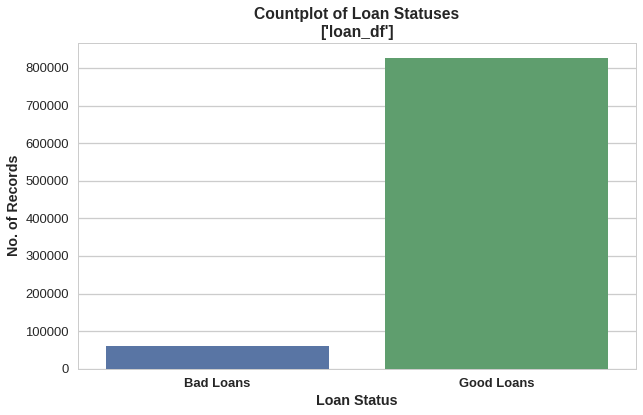

In [31]:
# Countplot of Loan Statuses
sns.countplot(x=response, data=loan_df)
plt.title('Countplot of Loan Statuses\n[\'loan_df\']')
plt.xticks(range(2), ['Bad Loans', 'Good Loans'], fontweight='bold')
plt.xlabel('Loan Status')
plt.ylabel('No. of Records')
plt.show()

#### G2. Importance of `'application_type'` attribute: Response variable distribution across the two types of loan applications.

**=> `'application_type'`: Not Important!**

Attribute: 'application_type':
---------------------------------
Check the uniqueness of 'application_type' attribute values...

Found 2 unique values in 887379 record lines.

Prints a frequency table of ('application_type', 'loan_status') values...

                               count  frequency
application_type loan_status                   
INDIVIDUAL       0             61174   0.999967
                 1            825694   0.999384
JOINT            0                 2   0.000033
                 1               509   0.000616




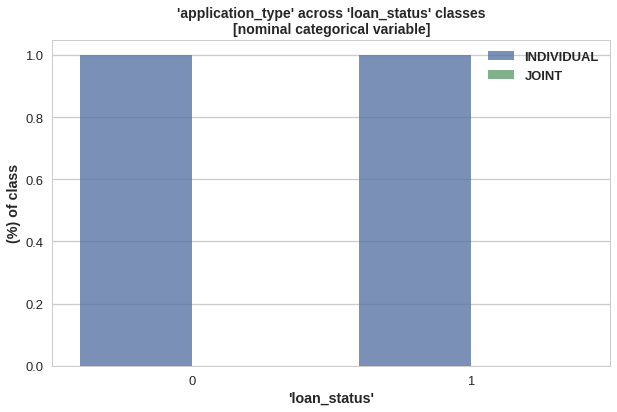

In [32]:
freq_tables(loan_df, ['application_type'], response,
            barplot=True, matplotlib_style='seaborn-whitegrid')

**=> `'verification_status_joint'`: Also Not Important!**

In [33]:
individual_loans_ix = (loan_df['application_type'] != 'JOINT')

for attrib in ['application_type', 'verification_status', 'verification_status_joint']:
    s = 'Attribute: "%s":' % attrib
    print(s)
    print('-' * (len(s)+3))
    pprint(loan_df.loc[individual_loans_ix, attrib].head(n=3))
    s = '\nValue Counts:'
    print(s)
    print('-' * (len(s)+3))
    pprint(pd.value_counts(loan_df.loc[individual_loans_ix, attrib]))
    print('\n')

Attribute: "application_type":
---------------------------------
0    INDIVIDUAL
1    INDIVIDUAL
2    INDIVIDUAL
Name: application_type, dtype: category
Categories (2, object): [INDIVIDUAL, JOINT]

Value Counts:
-----------------
INDIVIDUAL    886868
JOINT              0
Name: application_type, dtype: int64


Attribute: "verification_status":
------------------------------------
0           Verified
1    Source Verified
2       Not Verified
Name: verification_status, dtype: category
Categories (3, object): [Not Verified < Source Verified < Verified]

Value Counts:
-----------------
Source Verified    329424
Verified           290810
Not Verified       266634
Name: verification_status, dtype: int64


Attribute: "verification_status_joint":
------------------------------------------
0    Not Known
1    Not Known
2    Not Known
Name: verification_status_joint, dtype: category
Categories (4, object): [Not Known < Not Verified < Source Verified < Verified]

Value Counts:
-----------------
N

### H. Remove unimportant attributes & record lines from `"loan_df"` DataFrame

According to the previous discussion, the attributes below are not important for the response variable outcome, and we choose to remove them from the **`loan_df`** data set, to enhance the predictive performance of our model.

* **`'policy_code'`:** Publicly available (policy_code=1), New products not publicly available (policy_code=2).
* **`'pymnt_plan'`:** Indicates if a payment plan has been put in place for the loan.
* **`'application_type'`:** Indicates whether the loan is an individual application or a joint application with two co-borrowers.
* **`'verified_status_joint'`:** Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified.

Furthermore, keeping the record lines of the `'JOINT'` loan applications is now meaningless, and we drop them. The same is true for both the attributes **`'annual_inc_joint'`** and **`'dti_joint '`**, which now have **`'NA'`** values only. We also drop them.

Finally, we are going not to take in consideration the few **text attributes** that exist in **`loan_df`**, at least in this first stage of predictive modelling. These text attributes, which have been stored in the **`str_attribs`** list above, are:

* **`'desc'`:** Loan description provided by the borrower.
* **`'emp_title'`:** The job title supplied by the Borrower when applying for the loan (Note: employer title replaces Employer Name for all loans listed after 9/23/2013).
* **`'title'`:** The loan title provided by the borrower.
* **`'url'`:** URL for the LC page with listing data.

In [34]:
loan_df = loan_df.loc[individual_loans_ix,:]

In [35]:
loan_df.shape

(886868, 74)

In [36]:
unimp_attribs = ['policy_code', 
                 'pymnt_plan', 
                 'application_type', 
                 'verification_status_joint',
                 'annual_inc_joint',
                 'dti_joint']
for attrib in unimp_attribs:
    del loan_df[attrib]

In [37]:
loan_df.shape

(886868, 68)

Consequently, the attributes that we are going to further consider are enlisted below.

In [38]:
imp_attribs0 = list(loan_df.head()
                    .select_dtypes(exclude=['object']).columns)

In [39]:
loan_df.loc[:,imp_attribs0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886868 entries, 0 to 887378
Data columns (total 63 columns):
id                             886868 non-null int64
member_id                      886868 non-null int64
loan_amnt                      886868 non-null float64
funded_amnt                    886868 non-null float64
funded_amnt_inv                886868 non-null float64
term                           886868 non-null category
int_rate                       886868 non-null float64
installment                    886868 non-null float64
grade                          886868 non-null category
sub_grade                      886868 non-null category
emp_length                     886868 non-null category
home_ownership                 886868 non-null category
annual_inc                     886864 non-null float64
verification_status            886868 non-null category
issue_d                        886868 non-null datetime64[ns]
purpose                        886868 non-null category

## 3. Exploratory  Data Analysis

### A. Loan Amounts

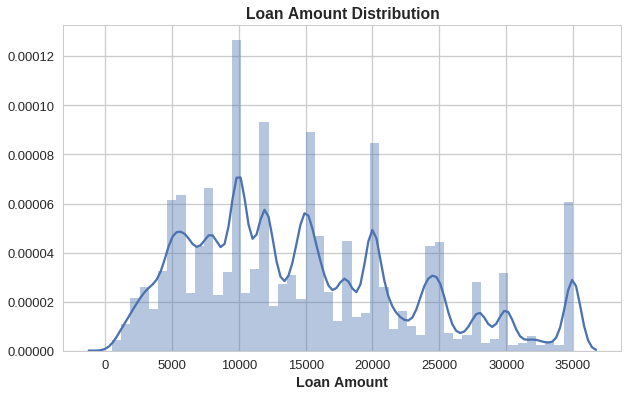

In [40]:
sns.distplot(loan_df.loc[:, 'loan_amnt'], hist=True, kde=True, rug=False,
             norm_hist=True, axlabel='Loan Amount')
plt.title('Loan Amount Distribution')
plt.show()

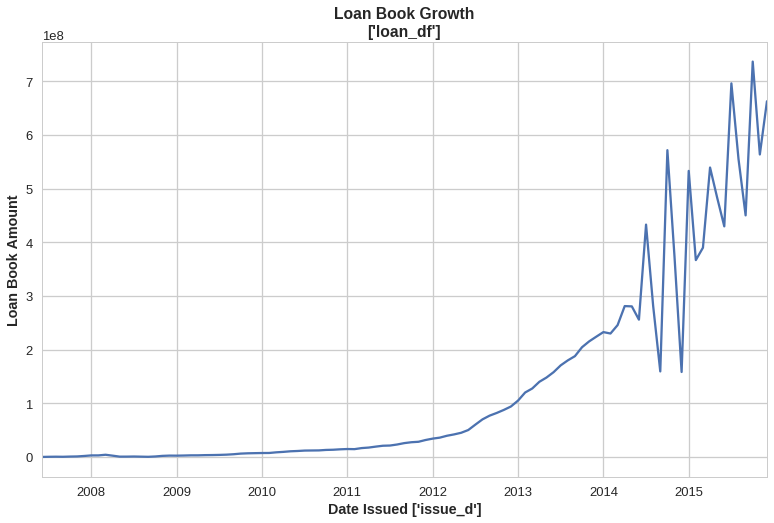

In [41]:
grouped = loan_df.groupby(by=['issue_d'])
grouped_agg = (grouped['loan_amnt']
               .agg({'loanbook_amnt': np.sum}))
grouped_agg_df = grouped_agg.reset_index()
grouped_agg_ts = pd.Series(data=grouped_agg_df['loanbook_amnt'].values,
                           index=grouped_agg_df['issue_d'])
del grouped_agg_df

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111)
grouped_agg_ts.plot(ax=ax)
ax.set_xlabel('Date Issued [\'issue_d\']')
ax.set_ylabel('Loan Book Amount')
ax.set_title('Loan Book Growth\n[\'loan_df\']')
plt.show()

### B. Loan Statuses & Grades

In [42]:
s = '\nBad Loans [Flagged as \'0\']:'
print(s)
print('-'*(len(s) + 3))
pprint(bad_loans)

s = '\nGood Loans [Flagged as \'1\']:'
print(s)
print('-'*(len(s) + 3))
pprint(good_loans)


Bad Loans [Flagged as '0']:
-------------------------------
['Default',
 'Does not meet the credit policy. Status:Charged Off',
 'Charged Off',
 'Late (31-120 days)',
 'Late (16-30 days)']

Good Loans [Flagged as '1']:
--------------------------------
['Issued',
 'In Grace Period',
 'Current',
 'Does not meet the credit policy. Status:Fully Paid',
 'Fully Paid']


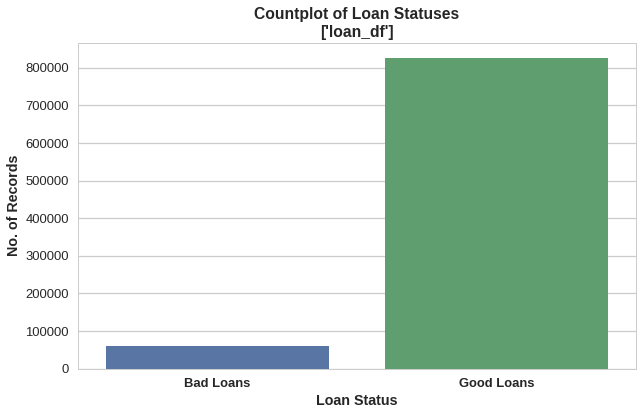

In [43]:
# Countplot of Loan Statuses
sns.countplot(x=response, data=loan_df)
plt.title('Countplot of Loan Statuses\n[\'loan_df\']')
plt.xticks(range(2), ['Bad Loans', 'Good Loans'], fontweight='bold')
plt.xlabel('Loan Status')
plt.ylabel('No. of Records')
plt.show()

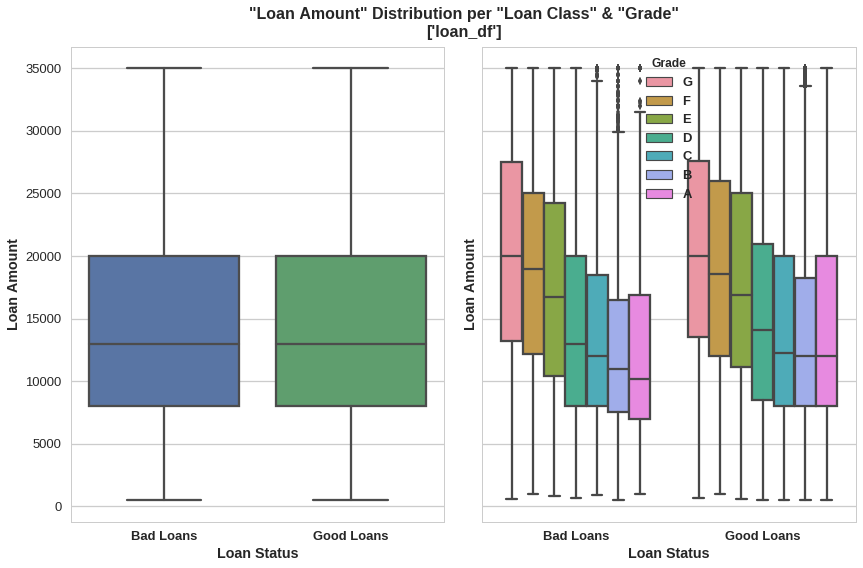

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,8), sharey=True)

sns.boxplot(x='loan_status', y='loan_amnt', data=loan_df, ax=ax1)
ax1.set_xticks(range(2))
ax1.set_xticklabels(['Bad Loans', 'Good Loans'], fontweight='bold')
ax1.set_xlabel('Loan Status')
ax1.set_ylabel('Loan Amount')

sns.boxplot(x='loan_status', y='loan_amnt', hue='grade', data=loan_df, ax=ax2)
ax2.set_xticks(range(2))
ax2.set_xticklabels(['Bad Loans', 'Good Loans'], fontweight='bold')
ax2.legend(loc='upper center', framealpha=0.5, prop={'weight': 'bold'})
ax2.legend_.set_title('Grade', prop={'weight': 'bold', 'size': 12})
ax2.set_xlabel('Loan Status')
ax2.set_ylabel('Loan Amount')

plt.suptitle('"Loan Amount" Distribution per "Loan Class" & "Grade"\n[\'loan_df\']',
             fontsize=16, fontweight='bold')
plt.tight_layout(h_pad=2, w_pad=2, rect=[0,0,0.93,0.93])
plt.show()

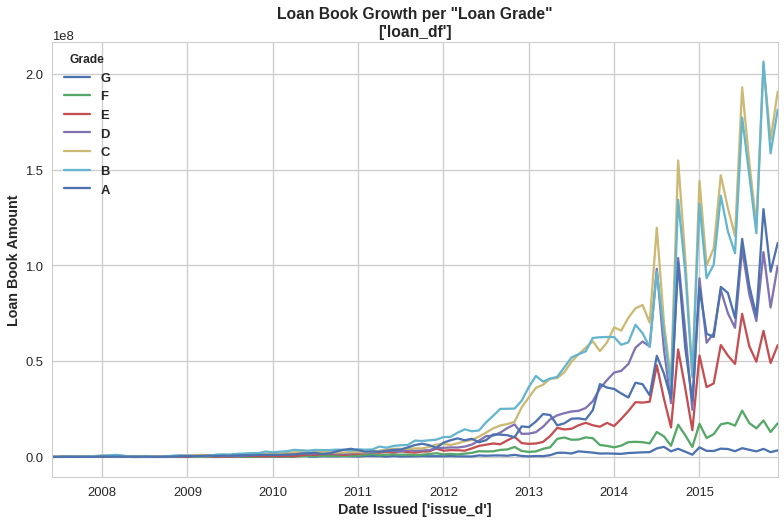

In [45]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111)

grouped = loan_df.groupby(by=['issue_d', 'grade'])
grouped_agg = (grouped['loan_amnt']
               .agg({'loanbook_amnt_per_grade': np.sum}))
grouped_agg_df = grouped_agg.reset_index()
grouped_agg_df1 = grouped_agg_df.pivot_table(values='loanbook_amnt_per_grade',
                                             index = 'issue_d',
                                             columns=['grade'])
grouped_agg_df1.plot(ax=ax)
ax.set_title('Loan Book Growth per "Loan Grade"\n[\'loan_df\']')
ax.legend(loc='best', prop={'weight': 'bold'})
ax.legend_.set_title('Grade', prop={'weight': 'bold', 'size': 12})
ax.set_xlabel('Date Issued [\'issue_d\']')
ax.set_ylabel('Loan Book Amount')
plt.show()

### C. Loan Book Distribution across the U.S. States

Here, we provide two choropleth maps concerning the **Loan Book Value** and the **Loan Book Volume distribution** across the **U.S. States**. To do so, we have used the [**`folium` Python library**](https://github.com/python-visualization/folium), a TopoJSON file which defines the U.S. States boundaries and it has been produced from a **cartographic boundary shapefile** that is provided from the official site of the [U.S. Census Bureau](https://www.census.gov/geo/maps-data/data/tiger-cart-boundary.html), and the Pandas DataFrame **`grouped_agg_df`**, where we aggregate the number, and the value of loans per U.S. State.

In [46]:
# Compute the "Loan Book Amount & Volume" per "US State"
grouped = loan_df.groupby(by=['addr_state'])
grouped_agg = grouped['loan_amnt'].agg({'loanbook_amnt_per_state': np.sum, 
                                        'loanbook_vol_per_state': np.count_nonzero})
grouped_agg_df = grouped_agg.reset_index()
grouped_agg_df.head()

addr_state  loanbook_vol_per_state  loanbook_amnt_per_state
0         AK                  2203.0             3.694285e+07
1         AL                 11191.0             1.644080e+08
2         AR                  6633.0             9.331845e+07
3         AZ                 20401.0             2.899420e+08
4         CA                129452.0             1.896790e+09

In [47]:
threshold_scale = []
quantiles = [0, 0.5, 0.75, 0.85, 0.9]
for q in quantiles:
    (threshold_scale
     .append(round(grouped_agg_df['loanbook_amnt_per_state'].quantile(q), 0)))

map1 = folium.Map(tiles='Mapbox Bright', location=[48, -102], zoom_start=3, control_scale=True)

map1.choropleth(geo_path=us_states_TopoJSON,
                data=grouped_agg_df,
                columns=['addr_state','loanbook_amnt_per_state'],
                key_on='feature.properties.STUSPS',
                topojson='objects.states',
                threshold_scale=threshold_scale,
                fill_color='YlOrRd',
                fill_opacity=0.5,
                line_opacity=0.3,
                legend_name='Loan Book Value by U.S. States',
                highlight=True,
                reset=True)

map1

In [48]:
threshold_scale = []
quantiles = [0, 0.5, 0.75, 0.85, 0.9]
for q in quantiles:
    (threshold_scale
     .append(round(grouped_agg_df['loanbook_vol_per_state'].quantile(q), 0)))

map2 = folium.Map(tiles='MapBox Bright', location=[48, -102], zoom_start=3, control_scale=True)

map2.choropleth(geo_path=us_states_TopoJSON, 
                data=grouped_agg_df,
                columns=['addr_state','loanbook_vol_per_state'],
                key_on='feature.properties.STUSPS',
                topojson='objects.states',
                threshold_scale=threshold_scale,
                fill_color='PuBu',
                fill_opacity=0.5,
                line_opacity=0.3,
                legend_name='Loan Book Volume by U.S. States',
                highlight=True,
                reset=True)

map2

### D. Loan Reasons across their Statuses ("Bad [`'0'`]"  /  "Good Loans [`'1'`]")

Attribute: 'purpose':
------------------------
Check the uniqueness of 'purpose' attribute values...

Found 14 unique values in 886868 record lines.

Prints a frequency table of ('purpose', 'loan_status') values...

                                 count  frequency
purpose            loan_status                   
car                0               556   0.009089
                   1              8306   0.010059
credit_card        0             10605   0.173358
                   1            195462   0.236725
debt_consolidation 0             37608   0.614771
                   1            486273   0.588926
educational        0                88   0.001439
                   1               335   0.000406
home_improvement   0              3186   0.052081
                   1             48617   0.058880
house              0               380   0.006212
                   1              3327   0.004029
major_purchase     0              1169   0.019109
                   1             1

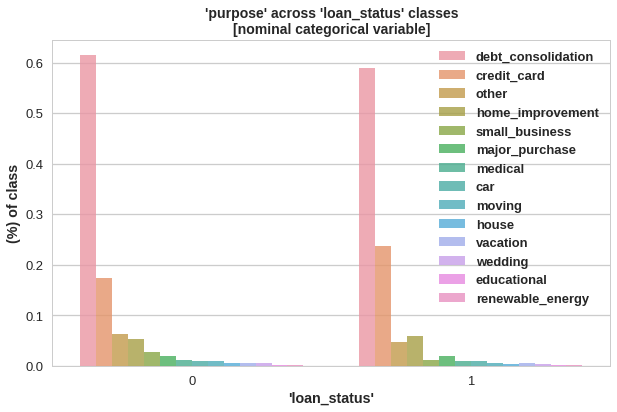

In [49]:
freq_tables(loan_df, ['purpose'], response,
            barplot=True, matplotlib_style='seaborn-whitegrid')

### E.  Loan Grades

#### E1. Loan Grades across their Statuses ("Bad [`'0'`]"  /  "Good Loans [`'1'`]")

Attribute: 'grade':
----------------------
Check the uniqueness of 'grade' attribute values...

Found 7 unique values in 886868 record lines.

Prints a frequency table of ('grade', 'loan_status') values...

                    count  frequency
grade loan_status                   
G     0              1175   0.019208
      1              4304   0.005213
F     0              4029   0.065861
      1             18993   0.023002
E     0              8837   0.144457
      1             61777   0.074818
D     0             14453   0.236261
      1            124966   0.151347
C     0             17166   0.280609
      1            228551   0.276799
B     0             12216   0.199693
      1            242217   0.293350
A     0              3298   0.053912
      1            144886   0.175472




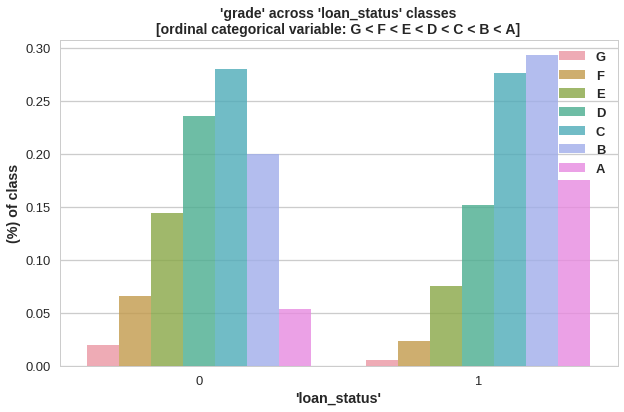

In [50]:
freq_tables(loan_df, ['grade'], response,
            barplot=True, matplotlib_style='seaborn-whitegrid')

#### E2. Interest Rate by Loan Grade

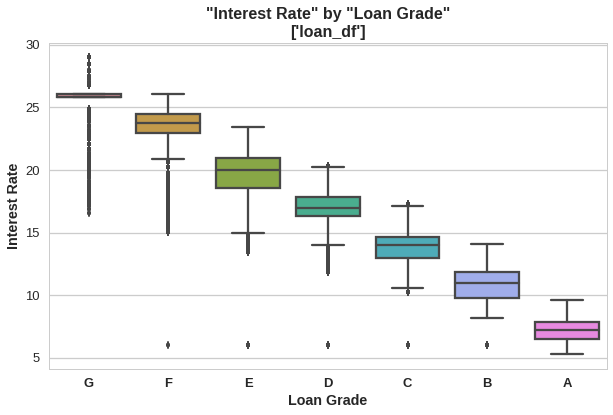

In [51]:
sns.boxplot(x='grade', y='int_rate', data=loan_df)
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate')
plt.title('"Interest Rate" by "Loan Grade"\n[\'loan_df\']',
          fontsize=16, fontweight='bold')
plt.xticks(range(7), list(loan_df['grade'].cat.categories),
           fontweight='bold')
plt.show()